# Activity: Build an LSTM to build a classifier for the Human Activity Recognition Using Smartphones Dataset #

Adapted from https://github.com/servomac/Human-Activity-Recognition/

Dataset information at https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones#





In [1]:
#All our imports
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from matplotlib.pyplot import *

In [2]:
#If you run into any errors running the cell above, you may need to install a package using !pip install ...

In [2]:
# Download the data: Only run this cell the first time
import wget
import os
import zipfile


#This is going to take a little while
if not os.path.isdir("UCI HAR Dataset"):
    print("downloading")
    wget.download("http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip")
    
    with zipfile.ZipFile("UCI HAR Dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("")
        
    print("done")
    
else:
    print("you already have it!")

you already have it!


In [2]:
# This is helper code from the github repo.
#No need to edit this, but it's helpful to glance through this code to see what it does

DATADIR = 'UCI HAR Dataset' 

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test


def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

def _count_classes(y):
    return len(set([tuple(category) for category in y]))

## Our LSTM model ##

This is where the important stuff happens. Try to understand everything happening here, and experiment with changing it once you've got the basic method working.


In [3]:
#Load the data and splits into training and test sets, where X is input and Y is output
X_train, X_test, Y_train, Y_test = load_data()

#Compute some information from the data, which we need to set up the model
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

In [26]:
n_classes

6

In [24]:
timesteps

128

In [25]:
input_dim

9

In [4]:
#After loading data, it's always a good idea to get a feel for what is in the data 

#For instance, we can use np.shape() to look at the shape of our examples
print(np.shape(X_train)) #this shows us we have 7352 training examples, where each input is 128x9 (9 channels of 128 samples each)

(7352, 128, 9)


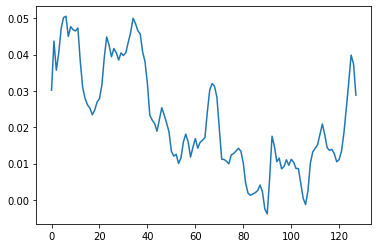

In [5]:
#We can peek at an individual example
exampleNumber = 0
channelNumber = 3
plot(np.transpose(X_train[exampleNumber])[channelNumber])

In [6]:
print(np.shape(Y_train)) #and we have a 6-dimensional output for each one of our 7352 examples

(7352, 6)


In [7]:
#We're using a "one-hot" encoding, which means that "1 0 0 0 0 0" means "class 1", "0 1 0 0 0 0" means class 2, and so on
print(Y_train[0]) #Prints the 6-dimensional output for the first training example

[0 0 0 0 1 0]


In [11]:
# This is where things get fun.

# Set some parameters to control training
# The number of epochs is the number of passes through the training data to make before you stop training
epochs = 5 # Play with this; might especially want to increase it once you know things are basically working

# The batch size is the number of examples to use to compute the gradient before updating the weights
# If batch_size is the same as the training set size, we use the whole training set every time. This is called "batch gradient descent"
# If batch_size is 1 then this is "stochastic gradient descent"
# If batch_size is something in between, then this is called "mini-batch" gradient descent
# Each choice will have different tradeoffs in terms of training time and ultimate accuracy, but there's no "right way" to do it
# For more info, see https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20batch%20size%20is%20a%20hyperparameter%20that%20defines%20the%20number,updating%20the%20internal%20model%20parameters.&text=When%20the%20batch%20size%20is,called%20mini%2Dbatch%20gradient%20descent. 
batch_size = 16 #You might want to play with this too

#How many hidden neurons do we want?
n_hidden = 32 #Feel free to change this


#This is the Keras code for specifying the network architecture:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.5)) #This is a method to try to prevent overfitting. See more at https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
model.add(Dense(n_classes, activation='sigmoid')) #a plain "dense" layer comes after the LSTM layer

#This line specifies how to train this network.
#You might want to play with these 3 values
#see more at https://keras.io/api/losses/, https://keras.io/api/optimizers/, https://keras.io/api/metrics/
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

#This line of code actually trains the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Evaluate the model on the test data
print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/5
460/460 [==============================] - 12s 23ms/step - loss: 1.1788 - accuracy: 0.5092 - val_loss: 0.9462 - val_accuracy: 0.6050
Epoch 2/5
460/460 [==============================] - 10s 22ms/step - loss: 0.8037 - accuracy: 0.6496 - val_loss: 0.7435 - val_accuracy: 0.7041
Epoch 3/5
460/460 [==============================] - 10s 22ms/step - loss: 0.7917 - accuracy: 0.6662 - val_loss: 0.7731 - val_accuracy: 0.6630
Epoch 4/5
460/460 [==============================] - 10s 22ms/step - loss: 0.6904 - accuracy: 0.6995 - val_loss: 0.7168 - val_accuracy: 0.7445
Epoch 5/5
460/460 [==============================] - 10s 22ms/step - loss: 0.5720 - accuracy: 0.7739 - val_loss: 0.5553 - val_accuracy: 0.8045
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 492       18         0        0                   0   
SITTING                  2      366       119      

In [8]:
# This is where things get fun.

# Set some parameters to control training
# The number of epochs is the number of passes through the training data to make before you stop training
epochs = 50 # Play with this; might especially want to increase it once you know things are basically working

# The batch size is the number of examples to use to compute the gradient before updating the weights
# If batch_size is the same as the training set size, we use the whole training set every time. This is called "batch gradient descent"
# If batch_size is 1 then this is "stochastic gradient descent"
# If batch_size is something in between, then this is called "mini-batch" gradient descent
# Each choice will have different tradeoffs in terms of training time and ultimate accuracy, but there's no "right way" to do it
# For more info, see https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20batch%20size%20is%20a%20hyperparameter%20that%20defines%20the%20number,updating%20the%20internal%20model%20parameters.&text=When%20the%20batch%20size%20is,called%20mini%2Dbatch%20gradient%20descent. 
batch_size = 16 #You might want to play with this too

#How many hidden neurons do we want?
n_hidden = 32 #Feel free to change this


#This is the Keras code for specifying the network architecture:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.5)) #This is a method to try to prevent overfitting. See more at https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
model.add(Dense(n_classes, activation='sigmoid')) #a plain "dense" layer comes after the LSTM layer

#This line specifies how to train this network.
#You might want to play with these 3 values
#see more at https://keras.io/api/losses/, https://keras.io/api/optimizers/, https://keras.io/api/metrics/
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

#This line of code actually trains the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

# Evaluate the model on the test data
print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/50
460/460 [==============================] - 16s 24ms/step - loss: 1.1258 - accuracy: 0.5324 - val_loss: 0.8067 - val_accuracy: 0.6295
Epoch 2/50
460/460 [==============================] - 11s 23ms/step - loss: 0.7920 - accuracy: 0.6355 - val_loss: 0.7596 - val_accuracy: 0.6800
Epoch 3/50
460/460 [==============================] - 11s 23ms/step - loss: 0.6784 - accuracy: 0.6835 - val_loss: 0.6945 - val_accuracy: 0.6875
Epoch 4/50
460/460 [==============================] - 11s 23ms/step - loss: 0.6105 - accuracy: 0.7442 - val_loss: 0.7143 - val_accuracy: 0.7014
Epoch 5/50
460/460 [==============================] - 11s 23ms/step - loss: 0.5786 - accuracy: 0.7599 - val_loss: 0.5641 - val_accuracy: 0.7740
Epoch 6/50
460/460 [==============================] - 11s 23ms/step - loss: 0.4783 - accuracy: 0.8025 - val_loss: 0.6870 - val_accuracy: 0.7231
Epoch 7/50
460/460 [==============================] - 11s 24ms/step - loss: 0.4297 - accuracy: 0.8387 - val_loss: 0.4652 - val_accuracy:

## Next steps: Experiment!

### 1. Try digging into & tweaking the results above. ###

* What happens with a different optimizer?
* Can you edit the code to use a validation set with early stopping, as well?
* What happens to the training accuracy, test/validation accuracy, and training time if you change the number of training examples?
* What happens if you change the dropout?
* Can you visualise this data (e.g., in Python using matplotlib, or in Excel) to get a sense of what it looks like?
* What else might you print each epoch, instead of just accuracy and loss?
* What else might you do if you were trying to release a commercial product that did this classification? How would you test it? How else might you edit the code to train your neural network? What would your main considerations be in deploying it?

### 2. Do more reading about all the options available to you in Keras ###
* https://keras.io/api/optimizers/
* https://keras.io/api/metrics/
* https://keras.io/api/losses/
* Use the `?` operation in Python to learn more about your options in code (e.g., `?model.compile`)


In [14]:
epochs = 10

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.5)) 
model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
230/230 [==============================] - 8s 30ms/step - loss: 1.3107 - accuracy: 0.4452 - val_loss: 1.0011 - val_accuracy: 0.5487
Epoch 2/10
230/230 [==============================] - 7s 30ms/step - loss: 0.8163 - accuracy: 0.6367 - val_loss: 0.7904 - val_accuracy: 0.6430
Epoch 3/10
230/230 [==============================] - 6s 25ms/step - loss: 0.7977 - accuracy: 0.6566 - val_loss: 0.7833 - val_accuracy: 0.6834
Epoch 4/10
230/230 [==============================] - 6s 25ms/step - loss: 0.7213 - accuracy: 0.6900 - val_loss: 0.7253 - val_accuracy: 0.6997
Epoch 5/10
230/230 [==============================] - 6s 25ms/step - loss: 0.5735 - accuracy: 0.7677 - val_loss: 0.6415 - val_accuracy: 0.7625
Epoch 6/10
230/230 [==============================] - 6s 25ms/step - loss: 0.5102 - accuracy: 0.8020 - val_loss: 0.6481 - val_accuracy: 0.7377
Epoch 7/10
230/230 [==============================] - 6s 26ms/step - loss: 0.4566 - accuracy: 0.8343 - val_loss: 0.5338 - val_accuracy: 0.8368

In [9]:
?Sequential()

Object `Sequential()` not found.


In [13]:
?model

In [10]:
?model.compile

In [11]:
?compile()

Object `compile()` not found.


In [12]:
?fit()

Object `fit()` not found.


In [15]:
epochs = 10

batch_size = 32

n_hidden = 64

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.5)) 
model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
230/230 [==============================] - 9s 35ms/step - loss: 1.2278 - accuracy: 0.4706 - val_loss: 0.9957 - val_accuracy: 0.5304
Epoch 2/10
230/230 [==============================] - 8s 33ms/step - loss: 0.8474 - accuracy: 0.6413 - val_loss: 0.7795 - val_accuracy: 0.6742
Epoch 3/10
230/230 [==============================] - 8s 33ms/step - loss: 0.6549 - accuracy: 0.7356 - val_loss: 0.6689 - val_accuracy: 0.7296
Epoch 4/10
230/230 [==============================] - 8s 33ms/step - loss: 0.6572 - accuracy: 0.7542 - val_loss: 1.0337 - val_accuracy: 0.6250
Epoch 5/10
230/230 [==============================] - 8s 33ms/step - loss: 0.7776 - accuracy: 0.7156 - val_loss: 0.5492 - val_accuracy: 0.8137
Epoch 6/10
230/230 [==============================] - 8s 33ms/step - loss: 0.4638 - accuracy: 0.8456 - val_loss: 0.5496 - val_accuracy: 0.8079
Epoch 7/10
230/230 [==============================] - 8s 33ms/step - loss: 0.2954 - accuracy: 0.9101 - val_loss: 0.3761 - val_accuracy: 0.8660

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

epochs = 10

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.5)) 
model.add(Dense(n_classes, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
230/230 [==============================] - 7s 26ms/step - loss: 1.0530 - accuracy: 0.5442 - val_loss: 0.8076 - val_accuracy: 0.6176
Epoch 2/10
230/230 [==============================] - 6s 25ms/step - loss: 0.6831 - accuracy: 0.7237 - val_loss: 0.6654 - val_accuracy: 0.8154
Epoch 3/10
230/230 [==============================] - 6s 25ms/step - loss: 0.4819 - accuracy: 0.8526 - val_loss: 0.6475 - val_accuracy: 0.8093
Epoch 4/10
230/230 [==============================] - 6s 25ms/step - loss: 0.5985 - accuracy: 0.8006 - val_loss: 0.8130 - val_accuracy: 0.6607
Epoch 5/10
230/230 [==============================] - 6s 25ms/step - loss: 0.4257 - accuracy: 0.8576 - val_loss: 0.5537 - val_accuracy: 0.8504
Epoch 6/10
230/230 [==============================] - 6s 25ms/step - loss: 0.3157 - accuracy: 0.8996 - val_loss: 0.5350 - val_accuracy: 0.8772
Epoch 7/10
230/230 [==============================] - 6s 25ms/step - loss: 0.2925 - accuracy: 0.9029 - val_loss: 0.3960 - val_accuracy: 0.8860

In [18]:
epochs = 10

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.5)) 
model.add(Dense(n_classes, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', 
              optimizer='RMSprop',
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
230/230 [==============================] - 7s 25ms/step - loss: 1.2574 - accuracy: 0.4771 - val_loss: 1.0466 - val_accuracy: 0.5623
Epoch 2/10
230/230 [==============================] - 7s 29ms/step - loss: 0.8602 - accuracy: 0.6454 - val_loss: 0.8068 - val_accuracy: 0.6739
Epoch 3/10
230/230 [==============================] - 7s 30ms/step - loss: 0.7150 - accuracy: 0.6959 - val_loss: 0.6983 - val_accuracy: 0.7333
Epoch 4/10
230/230 [==============================] - 6s 24ms/step - loss: 0.6294 - accuracy: 0.7644 - val_loss: 0.9484 - val_accuracy: 0.6342
Epoch 5/10
230/230 [==============================] - 6s 24ms/step - loss: 0.5171 - accuracy: 0.8188 - val_loss: 0.5918 - val_accuracy: 0.8022
Epoch 6/10
230/230 [==============================] - 5s 23ms/step - loss: 0.4277 - accuracy: 0.8610 - val_loss: 0.5111 - val_accuracy: 0.8202
Epoch 7/10
230/230 [==============================] - 5s 24ms/step - loss: 0.3603 - accuracy: 0.8923 - val_loss: 0.5313 - val_accuracy: 0.8412

In [19]:
epochs = 10

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
230/230 [==============================] - 7s 24ms/step - loss: 1.1951 - accuracy: 0.5166 - val_loss: 0.8916 - val_accuracy: 0.6783
Epoch 2/10
230/230 [==============================] - 5s 23ms/step - loss: 0.7429 - accuracy: 0.6968 - val_loss: 0.7199 - val_accuracy: 0.6834
Epoch 3/10
230/230 [==============================] - 5s 23ms/step - loss: 0.8200 - accuracy: 0.6483 - val_loss: 0.7651 - val_accuracy: 0.6600
Epoch 4/10
230/230 [==============================] - 5s 23ms/step - loss: 0.6692 - accuracy: 0.6970 - val_loss: 0.6780 - val_accuracy: 0.7136
Epoch 5/10
230/230 [==============================] - 5s 24ms/step - loss: 0.6063 - accuracy: 0.7359 - val_loss: 0.7217 - val_accuracy: 0.7319
Epoch 6/10
230/230 [==============================] - 6s 25ms/step - loss: 0.5420 - accuracy: 0.7779 - val_loss: 0.5758 - val_accuracy: 0.7930
Epoch 7/10
230/230 [==============================] - 5s 23ms/step - loss: 0.4093 - accuracy: 0.8630 - val_loss: 0.5201 - val_accuracy: 0.8297

In [20]:
epochs = 10

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='sigmoid'))

opt = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
230/230 [==============================] - 6s 21ms/step - loss: 1.2395 - accuracy: 0.4962 - val_loss: 1.4926 - val_accuracy: 0.4350
Epoch 2/10
230/230 [==============================] - 5s 20ms/step - loss: 1.0391 - accuracy: 0.5666 - val_loss: 1.4865 - val_accuracy: 0.2728
Epoch 3/10
230/230 [==============================] - 5s 20ms/step - loss: 1.5310 - accuracy: 0.3362 - val_loss: 1.3851 - val_accuracy: 0.4503
Epoch 4/10
230/230 [==============================] - 5s 20ms/step - loss: 1.2638 - accuracy: 0.4483 - val_loss: 1.2314 - val_accuracy: 0.5134
Epoch 5/10
230/230 [==============================] - 5s 20ms/step - loss: 1.1432 - accuracy: 0.5061 - val_loss: 1.1615 - val_accuracy: 0.5422
Epoch 6/10
230/230 [==============================] - 4s 20ms/step - loss: 1.0592 - accuracy: 0.5467 - val_loss: 1.3921 - val_accuracy: 0.4869
Epoch 7/10
230/230 [==============================] - 5s 20ms/step - loss: 1.0025 - accuracy: 0.5604 - val_loss: 1.4360 - val_accuracy: 0.4018

In [21]:
epochs = 50

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='sigmoid'))

opt = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/50
230/230 [==============================] - 7s 26ms/step - loss: 1.2593 - accuracy: 0.4652 - val_loss: 1.1089 - val_accuracy: 0.5351
Epoch 2/50
230/230 [==============================] - 6s 25ms/step - loss: 1.0542 - accuracy: 0.5507 - val_loss: 1.4520 - val_accuracy: 0.4293
Epoch 3/50
230/230 [==============================] - 6s 24ms/step - loss: 1.0003 - accuracy: 0.5919 - val_loss: 1.0190 - val_accuracy: 0.6101
Epoch 4/50
230/230 [==============================] - 6s 24ms/step - loss: 0.9342 - accuracy: 0.6099 - val_loss: 1.0929 - val_accuracy: 0.5677
Epoch 5/50
230/230 [==============================] - 6s 24ms/step - loss: 0.8140 - accuracy: 0.6597 - val_loss: 0.8749 - val_accuracy: 0.6356
Epoch 6/50
230/230 [==============================] - 6s 24ms/step - loss: 0.7204 - accuracy: 0.7002 - val_loss: 0.7034 - val_accuracy: 0.6797
Epoch 7/50
230/230 [==============================] - 6s 24ms/step - loss: 0.8468 - accuracy: 0.6789 - val_loss: 0.7496 - val_accuracy: 0.7027

In [23]:
epochs = 50

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/50
230/230 [==============================] - 7s 26ms/step - loss: 1.2132 - accuracy: 0.5015 - val_loss: 1.0403 - val_accuracy: 0.5779
Epoch 2/50
230/230 [==============================] - 5s 24ms/step - loss: 0.8188 - accuracy: 0.6684 - val_loss: 0.8099 - val_accuracy: 0.6854
Epoch 3/50
230/230 [==============================] - 6s 24ms/step - loss: 0.7018 - accuracy: 0.7081 - val_loss: 0.7936 - val_accuracy: 0.7170
Epoch 4/50
230/230 [==============================] - 6s 25ms/step - loss: 0.5401 - accuracy: 0.7783 - val_loss: 0.6250 - val_accuracy: 0.7631
Epoch 5/50
230/230 [==============================] - 6s 25ms/step - loss: 0.5288 - accuracy: 0.7773 - val_loss: 0.5879 - val_accuracy: 0.7760
Epoch 6/50
230/230 [==============================] - 6s 24ms/step - loss: 0.4784 - accuracy: 0.7935 - val_loss: 0.9044 - val_accuracy: 0.6468
Epoch 7/50
230/230 [==============================] - 6s 25ms/step - loss: 0.5841 - accuracy: 0.7456 - val_loss: 0.6326 - val_accuracy: 0.7380

In [27]:
epochs = 10

batch_size = 32

n_hidden = 32

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) #an LSTM layer
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
230/230 [==============================] - 6s 20ms/step - loss: 0.1333 - accuracy: 0.3915 - val_loss: 0.1066 - val_accuracy: 0.4852
Epoch 2/10
230/230 [==============================] - 4s 19ms/step - loss: 0.0972 - accuracy: 0.5103 - val_loss: 0.0930 - val_accuracy: 0.5504
Epoch 3/10
230/230 [==============================] - 4s 19ms/step - loss: 0.0901 - accuracy: 0.5898 - val_loss: 0.0891 - val_accuracy: 0.6573
Epoch 4/10
230/230 [==============================] - 4s 19ms/step - loss: 0.0758 - accuracy: 0.6840 - val_loss: 0.0726 - val_accuracy: 0.6970
Epoch 5/10
230/230 [==============================] - 4s 19ms/step - loss: 0.0663 - accuracy: 0.7346 - val_loss: 0.0689 - val_accuracy: 0.7133
Epoch 6/10
230/230 [==============================] - 5s 20ms/step - loss: 0.0605 - accuracy: 0.7661 - val_loss: 0.0630 - val_accuracy: 0.7384
Epoch 7/10
230/230 [==============================] - 4s 20ms/step - loss: 0.0541 - accuracy: 0.7935 - val_loss: 0.0560 - val_accuracy: 0.7587